In [1]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.1 MB/s eta 0:00:00


In [2]:
"""Import basic modules."""
import math
import os
import gc
import random
import pprint
import numpy as np               # For linear algebra
import pandas as pd              # For data manipulation
import matplotlib.pyplot as plt  # For 2D visualization
import seaborn as sns

# Warning Libraries
import warnings
warnings.filterwarnings("ignore")

from collections import Counter

"""Plotly visualization"""
from sklearn.preprocessing import ( LabelEncoder, RobustScaler,)
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.utils import resample

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Classic Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
import xgboost as xgb
import multiprocessing
import pickle, joblib

from IPython.display import Markdown, display

# utility function to print markdown string
def printmd(string):
    display(Markdown(string))

### Data Preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_churn_cleaned = pd.read_csv("./Telco-Customer-Churn-cleaned.csv")
df_churn_cleaned

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0.0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0.0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1.0
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0.0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0.0
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0.0
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0.0
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1.0


In [4]:
#Summary of the Data

printmd("**Column Info**")
display(df_churn_cleaned.info())
printmd("<br>**Datatypes Count**")
display(df_churn_cleaned.dtypes.value_counts())
printmd("<br>**Categorical Features**")
display(df_churn_cleaned.describe(include=['object']).T)

**Column Info**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


None

<br>**Datatypes Count**

object     15
float64     3
int64       2
dtype: int64

<br>**Categorical Features**

,count,unique,top,freq
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095
TechSupport,7043,3,No,3473


## Data Preprocessing
Steps we are going to go through in this phase :  
-  Splitting the Data :  Train, Test and Val Split
-  Encoding the Categorical Variables
-  Handling Class Imbalances
-  Feature Selection and Engineering
-  Scaling

### **Splitting the Data**

In [5]:
# Define the target variable name
label = 'Churn'

# Create the feature set by dropping the target variable column from the cleaned DataFrame
X = df_churn_cleaned.drop(columns = label)

# Create the label set by selecting only the target variable column
y = df_churn_cleaned[label]

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (7043, 19)
Labels shape: (7043,)


In [6]:
# Initialize StratifiedShuffleSplit to handle imbalanced data by maintaining the percentage of samples for each class
strat_shuf_split = StratifiedShuffleSplit(n_splits = 1, # Number of re-shuffling & splitting iterations
                                          test_size = 0.2, # Proportion of the dataset to include in the test split
                                          random_state= 42)  # Seed used by the random number generator for reproducibility

# Generate indices to split data into training and test set, ensuring stratified split
train_idx, test_idx = next(strat_shuf_split.split(X, y))

# Use the indices to create the training set (features and labels)
X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]

# Use the indices to create the test set (features and labels)
X_test  = X.iloc[test_idx]
y_test  = y.iloc[test_idx]

In [7]:
# Set up StratifiedShuffleSplit for creating a validation set, crucial for model evaluation during training
strat_shuf_split = StratifiedShuffleSplit(n_splits = 1,
                                          test_size = 0.25,
                                          random_state= 42)

# Generate indices to split the training data further into training and validation sets, maintaining class distribution
train_idx, val_idx = next(strat_shuf_split.split(X_train, y_train))

# Use the indices to partition the training set into a smaller training set and a validation set
X_train = X.iloc[train_idx]
y_train = y.iloc[train_idx]

X_val  = X.iloc[val_idx]
y_val  = y.iloc[val_idx]

# Print shapes of the new training, validation, and existing test datasets to verify the sizes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:{X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4225, 19)
y_train shape: (4225,)
X_val shape:(1409, 19)
y_val shape: (1409,)
X_test shape:(1409, 19)
y_test shape: (1409,)


### **Encoding the categorical variables**

In [8]:
# Identifying categorical and numerical columns in the dataset, excluding 'SeniorCitizen' from numerical due to its binary nature
cat_cols = list(set(X.columns) - set(X._get_numeric_data().columns))  # Categorical columns
num_cols = list(set(X._get_numeric_data().columns) - set({'SeniorCitizen'}))  # Numerical columns, excluding 'SeniorCitizen'

# Calculating the number of unique values for each categorical column
object_nunique = list(map(lambda col: X[col].nunique(), cat_cols))
# Creating a dictionary to map column names to their number of unique values
d = dict(zip(cat_cols, object_nunique))

# Printing the number of unique entries for each categorical column, sorted in ascending order of cardinality
print("Number of unique entries by column, in ascending order:\n")
sorted_cols_by_cardinality = sorted(d.items(), key=lambda x: x[1])  # Sorting columns by their cardinality
display(pd.DataFrame(sorted_cols_by_cardinality, columns=['Columns', 'Cardinality']))  # Displaying the sorted information

# Printing the totals of categorical and numerical columns for reference
print("Total Categorical Columns", len(cat_cols))
print("Total Numerical Columns", len(num_cols))

Number of unique entries by column, in ascending order:



,Columns,Cardinality
0,gender,2
1,Dependents,2
2,PhoneService,2
3,PaperlessBilling,2
4,Partner,2
5,StreamingMovies,3
6,StreamingTV,3
7,TechSupport,3
8,Contract,3
9,DeviceProtection,3


Total Categorical Columns 15
Total Numerical Columns 3


**Dataset has maximum cardinality value of 4 which is comparatively low**

In [9]:
# Initialize encoders and scaler
label_encoder = LabelEncoder()
transformer = RobustScaler()

# Encoding all categorical features using LabelEncoder
for col in cat_cols:
    # Fit on the entire dataset to ensure all categories are captured
    full_data = pd.concat([X[col], X_train[col], X_val[col], X_test[col]], axis=0)
    label_encoder.fit(full_data) # Fit encoder to combined data

    # Apply the fitted encoder to each split
    X[col] = label_encoder.transform(X[col])
    X_train[col] = label_encoder.transform(X_train[col])
    X_val[col] = label_encoder.transform(X_val[col])
    X_test[col] = label_encoder.transform(X_test[col])

# Encoding target variable
y = label_encoder.fit_transform(y)
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

### **Feature Selection**

Using Recursive Feature Elimination with Cross-Validation (RFECV) alongside a RandomForestClassifier we would identify and select a subset of features that contribute most to predicting the target variable y

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def recursive_selection(X, y):
    """
    Applies Recursive Feature Elimination with Cross-Validation (RFECV) to select features.

    Parameters:
    - X: Feature set.
    - y: Target variable set.

    Returns:
    - features_idx: Indices of the selected features.
    """
    # Initialize the RandomForestClassifier as the base model for feature selection
    # Using 'entropy' criterion for information gain and setting random_state for reproducibility
    rfm = RandomForestClassifier(criterion='entropy', random_state=42, n_jobs=-1)

    # Initialize RFECV for recursive feature elimination with cross-validation
    # Specifies the minimum number of features to select and the cross-validation splitting strategy
    rfe = RFECV(estimator=rfm, min_features_to_select=17, cv=5)

    # Fit RFECV to the data to find the optimal number of features
    rfe = rfe.fit(X, y)

    # Get the indices of the selected features
    features_idx = rfe.get_support(indices=True)

    return features_idx

In [11]:
# Obtain the indices of the best features selected by recursive feature selection
features_idx = recursive_selection(X_train, y_train)

# Subset the training, validation, and test sets to include only the selected features
X_train = X_train.iloc[: ,features_idx]
X_val = X_val.iloc[: ,features_idx]
X_test = X_test.iloc[: ,features_idx]

# Print the shapes of the modified datasets to verify the feature selection process
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape:{X_val.shape}")
print(f"X_test shape:{X_test.shape}")

X_train shape: (4225, 19)
X_val shape:(1409, 19)
X_test shape:(1409, 19)


### **Scaling**

Since we woud be using models like XGBoost and LightGM which do not strictly require feature scaling before training a model. This is because they are tree-based model, and tree-based models are generally invariant to the scale of the features.

In [13]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create copies of the datasets for scaling
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Scaling numerical features
X_train_scaled[num_cols] = transformer.fit_transform(X_train_scaled[num_cols])
X_val_scaled[num_cols] = transformer.transform(X_val_scaled[num_cols])
X_test_scaled[num_cols] = transformer.transform(X_test_scaled[num_cols])

# Now X_train_scaled, X_val_scaled, X_test_scaled contain the scaled numerical features and would be used on models that require it
# while the original X_train, X_val, X_test remain unchanged for use with models like XGBoost

## **Modelling**
For the churn prediction we would be evaluating a couple of models and the one that works best we would be utilizing. We chose these models for the following reasons  :  


- Logistic Regression
    - Reason: Provides a straightforward and interpretable model for binary classification.
    - Suitability: Ideal for establishing a baseline and understanding feature influence on churn prediction due to its simplicity and interpretability.

- K-Nearest Neighbors (KNN)
    - Reason: Captures non-linear relationships through similarity-based predictions.
    - Suitability: Useful for identifying churn patterns in localized clusters of data, relying on the premise that similar customers exhibit similar behaviors.

- XGBoost
    - Reason: Offers high performance and efficiency with gradient boosting techniques.
    - Suitability: Handles complex nonlinear patterns and provides insights through feature importance, making it powerful for diverse datasets.

- LightGBM
    - Reason: Optimized for speed and memory usage, excels in large datasets.
    - Suitability: Efficient with categorical and continuous data, effective for imbalanced datasets like churn prediction, where rapid model development and iteration are key.
    
Each model brings a unique set of strengths to the project, from interpretability and simplicity to sophisticated learning capabilities, catering to the complexities of churn prediction.

### **Model Pipeline**

In [ ]:
# Initialize a dictionary to hold model names and performance metrics
data_dict = {
    "Model": ["LogisticRegression", "KNN", "XGBoost", "Lightgbm"],
    "Log-loss": [0, 0, 0, 0],  # Placeholder for log-loss values
    "Acuraccy": [0, 0, 0, 0],  # Placeholder for accuracy values
    "Precision": [0, 0, 0, 0],  # Placeholder for precision values
    "Recall": [0, 0, 0, 0],  # Placeholder for recall values
    "F1-score": [0, 0, 0, 0],  # Placeholder for F1-score values
    "AUC": [0, 0, 0, 0]  # Placeholder for AUC values
}

# Create a DataFrame from the dictionary to track results
track_result = pd.DataFrame(data_dict, columns=["Model", "Log-loss",
                                                "Acuraccy", "Precision",
                                                "Recall", "F1-score", "AUC"])

def model_results(model, y_val, y_pred):
    """
    Updates the tracking DataFrame with performance metrics for a given model.

    Parameters:
    - model: String name of the model being evaluated.
    - y_val: Actual target values.
    - y_pred: Predicted target values by the model.

    Returns:
    - track_result: DataFrame with updated performance metrics for the model.
    """

    # Find the index in the DataFrame for the current model
    model_idx = track_result[track_result["Model"] == model].index

    # Update the DataFrame with the calculated performance metrics for the model
    track_result.loc[model_idx, "Log-loss"] = log_loss(y_val, y_pred)
    track_result.loc[model_idx, "Acuraccy"] = accuracy_score(y_val, y_pred)
    track_result.loc[model_idx, "Precision"] = precision_score(y_val, y_pred)
    track_result.loc[model_idx, "Recall"] = recall_score(y_val, y_pred)
    track_result.loc[model_idx, "F1-score"] = f1_score(y_val, y_pred)
    track_result.loc[model_idx, "AUC"] = roc_auc_score(y_val, y_pred)

    return track_result
import matplotlib.pyplot as plt
import numpy as np


def plot_feature_importance(model, feature_names, title='Feature Importance'):
    """
    Plots the feature importance of a trained model.

    Parameters:
    - model: The trained model.
    - feature_names: List of feature names.
    - title: Title of the plot.
    """
    # Get feature importances from the model
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # For models with coefficients (like Logistic Regression), take the absolute values
        importances = np.abs(model.coef_[0])
    else:
        raise ValueError("Model does not have feature_importances_ or coef_ attribute.")

    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(indices)), importances[indices], align="center")
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, len(indices)])
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

### **Train the Models**

### **Logistic Regression**

In [ ]:
## Train
# Initialize the Logistic Regression model
lgr_model = LogisticRegression(max_iter=1000)

# Fit the model on the scaled training dataset
lgr_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
## Training performance

# Calculate training and validation accuracy for Logistic Regression model
acc_lgr_train = lgr_model.score(X_train_scaled, y_train)
acc_lgr_val = lgr_model.score(X_val_scaled, y_val)

#Print out the results

print(f"Logistic Regression Train Accuracy:{np.round(acc_lgr_train,2)} \nLogistic Regression Validation Accuracy: {np.round(acc_lgr_val,2)}")

Logistic Regression Train Accuracy:0.81 
Logistic Regression Validation Accuracy: 0.8


In [ ]:
## Baseline performance

# Predict validation set outcomes using the logistic regression model
bs_pred = lgr_model.predict(X_val_scaled)

# Update performance tracking with results from the logistic regression model

model_results('LogisticRegression', y_val, bs_pred)

,Model,Log-loss,Acuraccy,Precision,Recall,F1-score,AUC
0,LogisticRegression,7.213847,0.799858,0.642857,0.535135,0.584071,0.714632
1,KNN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,XGBoost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Lightgbm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### **KNeighbors Model**

In [ ]:
# Initialize the K-Nearest Neighbors (KNN) classifier
knn_model = KNeighborsClassifier()

# Fit the KNN model to the scaled training data
# It's important to use scaled data because KNN calculates the distance between instances
# and scaling ensures that all features contribute equally to the distance computation.
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [ ]:
## Training performance


# Calculate training and validation accuracy for KNN model
acc_knn_train = knn_model.score(X_train_scaled, y_train)
acc_knn_val = knn_model.score(X_val_scaled, y_val)

#Print out the results
print(f"KNeighbors Train Accuracy:{np.round(acc_knn_train,2)} \nKNeighbors  Validation Accuracy: {np.round(acc_knn_val,2)}")

KNeighbors Train Accuracy:0.83 
KNeighbors  Validation Accuracy: 0.75


In [ ]:
## KNeighbors performance

# Predict validation set outcomes using the  model
knn_pred = knn_model.predict(X_val_scaled)

# Update performance tracking with results from the knn model
model_results('KNN', y_val, knn_pred)

,Model,Log-loss,Acuraccy,Precision,Recall,F1-score,AUC
0,LogisticRegression,7.213847,0.799858,0.642857,0.535135,0.584071,0.714632
1,KNN,8.927775,0.752307,0.530792,0.489189,0.509142,0.667597
2,XGBoost,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Lightgbm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## **Xgboost Model**

In [ ]:
# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Fit the xgb model to the training data
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
## Training performance

# Calculate training and validation accuracy for XGB model
acc_xgb_train = xgb_model.score(X_train, y_train)
acc_xgb_val = xgb_model.score(X_val, y_val)

#Print out the results
print(f"XGB Train Accuracy:{round(acc_xgb_train,2)} \nXGB Validation Accuracy: {round(acc_xgb_val,2)}")

XGB Train Accuracy:0.96 
XGB Validation Accuracy: 0.78


In [ ]:
## Baseline performance

# Predict validation set outcomes using the  model
xgb_pred = xgb_model.predict(X_val)

# Update performance tracking with results from the knn model
model_results('XGBoost', y_val, xgb_pred)

,Model,Log-loss,Acuraccy,Precision,Recall,F1-score,AUC
0,LogisticRegression,7.213847,0.799858,0.642857,0.535135,0.584071,0.714632
1,KNN,8.927775,0.752307,0.530792,0.489189,0.509142,0.667597
2,XGBoost,8.032439,0.777147,0.592715,0.483784,0.532738,0.682700
3,Lightgbm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### **LightGBM**

In [ ]:
# Initialize the LightGBM classifier
lgb_model = lgb.LGBMClassifier()

# Fit the lgb model to the training data
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1118, number of negative: 3107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264615 -> initscore=-1.022116
[LightGBM] [Info] Start training from score -1.022116


LGBMClassifier()

In [ ]:
## Training performance

# Calculate training and validation accuracy for the LightGBM model
acc_lgb_train = lgb_model.score(X_train, y_train)
acc_lgb_val = lgb_model.score(X_val, y_val)

#Print out the results
print(f"LGB Train Accuracy:{round(acc_lgb_train,2)} \nLGB Validation Accuracy: {round(acc_lgb_val,2)}")

LGB Train Accuracy:0.9 
LGB Validation Accuracy: 0.78


In [ ]:
## Baseline performance

# Predict validation set outcomes using the  model
lgb_pred = lgb_model.predict(X_val)

# Update performance tracking with results from the LightGBM model
model_results('Lightgbm', y_val, lgb_pred)

,Model,Log-loss,Acuraccy,Precision,Recall,F1-score,AUC
0,LogisticRegression,7.213847,0.799858,0.642857,0.535135,0.584071,0.714632
1,KNN,8.927775,0.752307,0.530792,0.489189,0.509142,0.667597
2,XGBoost,8.032439,0.777147,0.592715,0.483784,0.532738,0.682700
3,Lightgbm,7.853372,0.782115,0.606061,0.486486,0.539730,0.686939


**Summary of Performances:**
- Logistic Regression shows the least drop between training and validation accuracy, indicating a relatively good generalization. However, it also displays moderate precision and recall, suggesting room for improvement in correctly identifying positive cases.

- KNeighbors (KNN) experiences a significant drop from training to validation accuracy, the largest among the models, indicating potential overfitting to the training data. Its precision, recall, and F1-score are the lowest, suggesting it struggles the most with class imbalance.

- XGBoost has the highest training accuracy, suggesting it learns the training data well, but sees a substantial drop in validation accuracy, hinting at overfitting. Precision, recall, and F1-scores are moderate, reflecting challenges in handling class imbalance.

- LightGBM (LGB) has performance metrics similar to XGBoost, with a high training accuracy but lower validation accuracy, indicating overfitting. Its precision, recall, and F1-score are slightly better than XGBoost, suggesting a marginally better handling of the imbalanced classes.

**Influence on Optimization Techniques:**

The observed performance metrics, especially the validation accuracies and the gap between training and validation accuracies, suggest that class imbalance significantly affects model performance. Overfitting is noticeable for models that achieve high training accuracy (XGBoost and LightGBM), indicating they learn to predict the majority class well but fail to generalize this knowledge to correctly classify the minority class in unseen data.

gender              0.021888
SeniorCitizen       0.026229
Partner             0.023141
Dependents          0.023330
tenure              0.032966
PhoneService        0.025067
MultipleLines       0.022983
InternetService     0.098972
OnlineSecurity      0.079962
OnlineBackup        0.028711
DeviceProtection    0.023228
TechSupport         0.051328
StreamingTV         0.024621
StreamingMovies     0.034289
Contract            0.363552
PaperlessBilling    0.037339
PaymentMethod       0.027457
MonthlyCharges      0.028658
TotalCharges        0.026281
dtype: float32


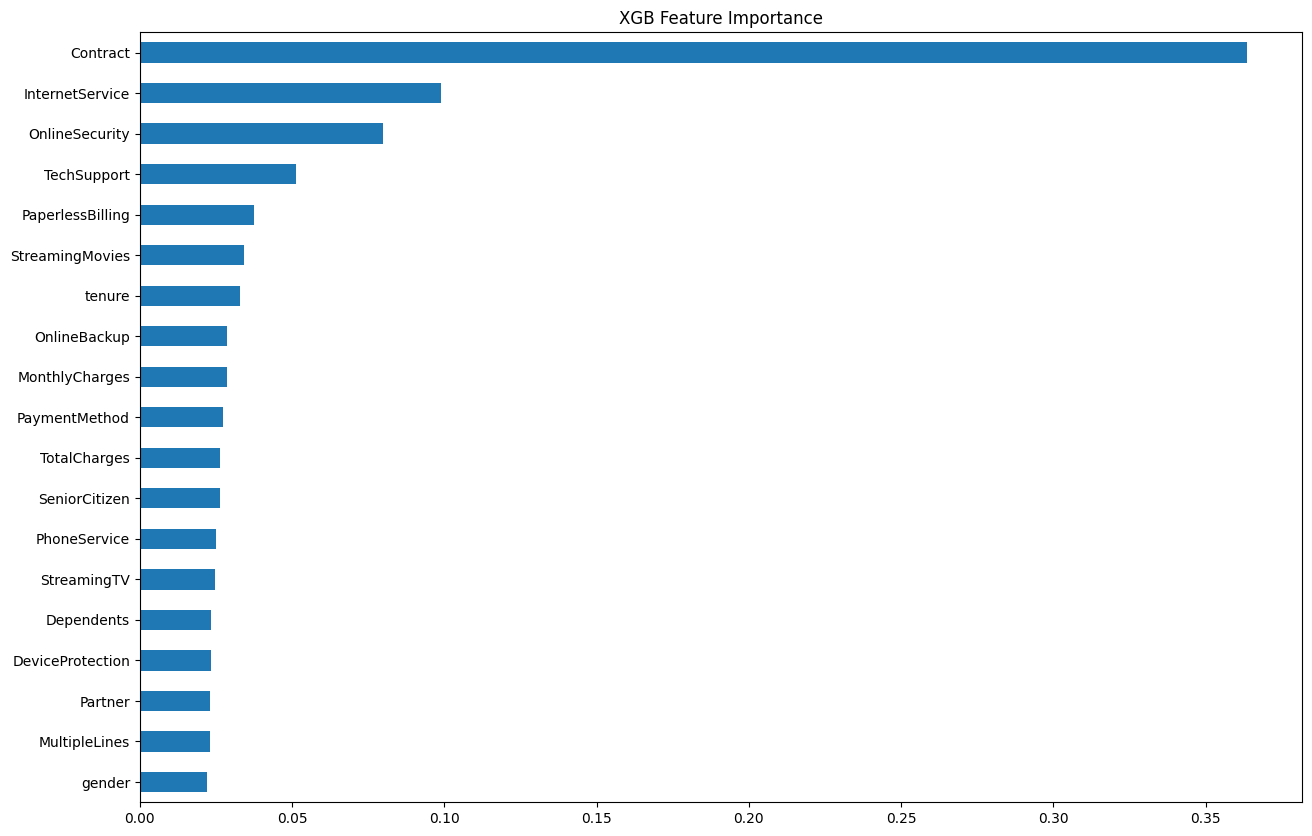

In [ ]:
## Feature importance
importance_xgb = pd.Series(xgb_model.feature_importances_, index = X_train.columns)

#bar plot
importance_xgb.sort_values(ascending= True).plot(kind = 'barh', title="XGB Feature Importance", figsize = (15, 10));

print(importance_xgb)

## **Optimising the model**
Given these insights, the following optimization techniques will be considered to address class imbalance and improve model generalization:

- SMOTE (Synthetic Minority Over-sampling Technique): To balance the dataset by creating synthetic samples of the minority class. Applying SMOTE should help improve recall and F1-scores by providing the models with more examples of the minority class to learn from.

- Hyperparameter Tuning

- Ensemble Methods: Exploring ensemble methods that might naturally handle class imbalance better, such as bagging and boosting techniques. Ensembles of models that have been individually tuned to address imbalance might perform better.

- Evaluation Metric Selection: Opting for metrics that capture the effect of class imbalance better during optimization, such as AUC, F1-score, or average precision, guiding the model to improve in areas critical for imbalanced classification tasks.

### **Handling Class Imbalance**

Class Distribution in Percentage:
 0.0    73.463013
1.0    26.536987
Name: Churn, dtype: float64


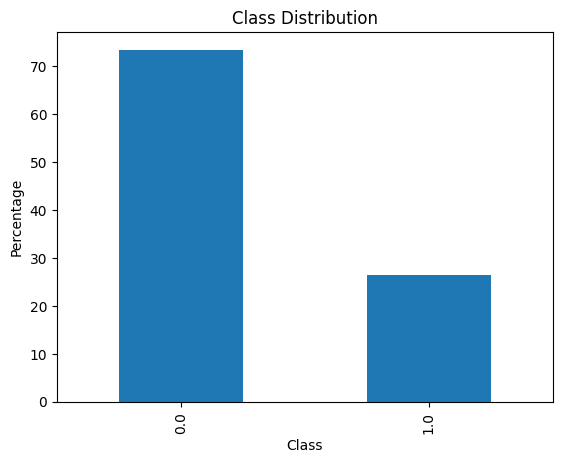

In [ ]:
import pandas as pd

# Assuming df is your DataFrame and 'Churn' is the target column
class_distribution = df_churn_cleaned['Churn'].value_counts(normalize=True) * 100
print("Class Distribution in Percentage:\n", class_distribution)

# Visual representation
import matplotlib.pyplot as plt

class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.title('Class Distribution')
plt.show()


In Handling the class imbalances we would be using the SMOTE technique:

SMOTE (Synthetic Minority Over-sampling Technique) is an oversampling technique used to address this issue by creating synthetic samples from the minority class.

- Effectiveness: SMOTE is effective for dealing with imbalanced datasets by creating synthetic examples rather than simply duplicating minority class examples, which helps in adding more diversity to the training dataset.

- Avoids Overfitting: Unlike simple oversampling techniques that replicate the minority class examples and can lead to overfitting, SMOTE generates new examples, helping the model generalize better.

- Wide Applicability: SMOTE has been widely used and validated in various domains and scenarios, proving its effectiveness across different datasets and problems.

In [12]:
def oversampling(alg, X, y):
    """
    Function to apply oversampling to the dataset using a specified algorithm.

    Parameters:
    - alg: The oversampling algorithm class to use (e.g., SMOTE).
    - X: The feature set.
    - y: The target variable set.

    Returns:
    - X_resampled: The resampled feature set after applying oversampling.
    - y_resampled: The resampled target variable set after applying oversampling.
    """
    # Initialize the oversampling algorithm with a random state for reproducibility and n_jobs for parallel processing
    alg_over = alg(random_state=42, n_jobs=-1)
    # Fit the algorithm to the data and resample it
    X_resampled, y_resampled = alg_over.fit_resample(X, y)
    return X_resampled, y_resampled

# Apply SMOTE only on the training data to handle class imbalance
X_train, y_train = oversampling(SMOTE, X, y)

print(f"X_train_resampled shape: {X_train.shape}")
print(f"y_train_resampled shape: {y_train.shape}")

X_train_resampled shape: (10348, 19)
y_train_resampled shape: (10348,)


### **Hyperparameter Tuning Using Hyperopt**

Considering we are working with sophisticated models (XGBoost, LightGBM, KNN) and potentially building ensemble models, Hyperopt is a suitable hyperameter tuning choice due to it's efficiency in navigating large hyperparameter spaces.

The parameters for the hyper parameter tuning of the individual models were sourced from the official Hyperopt Documentation and the following sources :

- [Resource XGB Hyperopt Parameters](https://www.kaggle.com/code/kabure/extensive-eda-and-modeling-xgb-hyperopt)
- [Resource LGB Hyperopt Parameters](https://www.kaggle.com/code/kabure/simple-eda-lightgbm-autotuning-w-hyperopt#I-will-keep-working-on-this-dataset-exploration)
- [Resource KNN Hyperopt Parameters](https://www.kaggle.com/code/arunimsamudra/k-nn-with-hyperparameter-tuning)

In [15]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

space = {
         'subsample': hp.uniform('subsample', 0.4, 1.0),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1.0),
         'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(1.0)),
         'min_child_weight': hp.quniform('min_child_weight',3, 10, 1),
         'max_depth': scope.int(hp.uniform('max_depth', 1, 12)),
         'gamma': hp.quniform('gamma', 0, 20, 1),
         'reg_alpha': hp.uniform('reg_alpha', 0.01, 4.0),
         'reg_lambda': hp.quniform('reg_lambda', 4, 40, 1),
         'n_estimators': scope.int(hp.uniform('n_estimators', 100, 2000)),
         'seed': 100,
         'tree-method':'gpu-hist'
    }


def objective(param):

  model = xgb.XGBClassifier(**param)

  auc = cross_val_score(model, X_train, y_train, cv = 5).mean()

  return {'loss': -auc, 'status': STATUS_OK }


trials = Trials()

xgb_best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 100,
            trials = trials
            )

print(xgb_best)

100%|██████████| 100/100 [12:35<00:00,  7.56s/trial, best loss: -0.8321550470133067]
{'colsample_bytree': 0.6405205997483123, 'gamma': 0.0, 'learning_rate': 0.045731653433974034, 'max_depth': 6.255256202949517, 'min_child_weight': 4.0, 'n_estimators': 1567.2362208012314, 'reg_alpha': 2.217211312294435, 'reg_lambda': 20.0, 'subsample': 0.787151428622601}


In [38]:
#Hyperparameter Tuning for LGBM
# Define searched space
space = {
              'objective': 'binary', # binary target
              'n_estimators': scope.int(hp.uniform('n_estimators', 50, 1000)),  # Reduced upper limit
               'max_depth': scope.int(hp.uniform('max_depth', 5, 64)),
               'num_leaves': scope.int(hp.uniform('num_leaves', 5 , 1000)),
              'subsample': hp.uniform('subsample', 0.4, 1.0),
              'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1.0),
                'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(1.0)),
               'reg_alpha': hp.uniform('reg_alpha', 0.01, 4.0),
               'reg_lambda': hp.quniform('reg_lambda', 4, 40, 1),
               'min_child_samples': hp.choice('min_child_samples', [20, 45, 70, 100])}

def objective(param):
  model = lgb.LGBMClassifier(**param)
  # AUC scorer for cross-validation
  auc_scorer = make_scorer(roc_auc_score, needs_proba=True, greater_is_better=True)
  # Perform cross-validation and return the mean AUC score
  auc = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=3, scoring=auc_scorer).mean()
  return {'loss': -auc, 'status': STATUS_OK }


trials = Trials()

lgb_best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 15,
            trials = trials
            )

print(lgb_best)

100%|██████████| 15/15 [01:27<00:00,  5.81s/trial, best loss: -0.9213163877099526]
{'colsample_bytree': 0.9624957483546209, 'learning_rate': 0.3752033371624481, 'max_depth': 11.718058774375702, 'min_child_samples': 0, 'n_estimators': 263.6315523855453, 'num_leaves': 336.8073628353035, 'reg_alpha': 0.20066535950522407, 'reg_lambda': 34.0, 'subsample': 0.4019513981001751}


In [16]:
# Define the search space for KNN hyperparameters
space = {
    'n_neighbors': hp.choice('n_neighbors', range(1, 50)),
    'weights': hp.choice('weights', ['uniform', 'distance']),
    'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
    'leaf_size': hp.choice('leaf_size', range(1, 50)),
    'p': hp.choice('p', [1, 2])  # 1=manhattan_distance, 2=euclidean_distance
}

def objective(param):
  model = KNeighborsClassifier(**param)
  # AUC scorer for cross-validation
  auc_scorer = make_scorer(roc_auc_score, needs_proba=True, greater_is_better=True)
  # Perform cross-validation and return the mean AUC score
  auc = cross_val_score(model, X_train_scaled, y_train, n_jobs=-1, cv=5, scoring=auc_scorer).mean()
  return {'loss': -auc, 'status': STATUS_OK }


trials = Trials()

knn_best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 100,
            trials = trials
            )

print(knn_best)

100%|██████████| 100/100 [01:19<00:00,  1.25trial/s, best loss: -0.9039723629372236]
{'algorithm': 1, 'leaf_size': 24, 'n_neighbors': 19, 'p': 0, 'weights': 1}


### Revaluating the Models

In [40]:
### Retrain Models with optimised parameters

#XGBOOST
xgb_optimised_model = xgb.XGBClassifier(
    learning_rate = xgb_best['learning_rate'],
    max_depth = int(xgb_best['max_depth']),
    subsample = xgb_best['subsample'],
    colsample_bytree = xgb_best['colsample_bytree'],
    min_child_weight = int(xgb_best['min_child_weight']),
    reg_lambda = xgb_best['reg_lambda'],
    reg_alpha = xgb_best['reg_alpha'],
    gamma = int(xgb_best['gamma']),
    n_estimators = int(xgb_best['n_estimators']),
    seed = 100
)

xgb_optimised_model.fit(X_train, y_train)


# LightGBM
lgb_optimised_model = lgb.LGBMClassifier(
    objective = 'binary',
    min_child_samples = lgb_best['min_child_samples'],
    learning_rate = lgb_best['learning_rate'],
    max_depth = int(lgb_best['max_depth']),
    subsample = lgb_best['subsample'],
    colsample_bytree = lgb_best['colsample_bytree'],
    reg_lambda = lgb_best['reg_lambda'],
    reg_alpha = lgb_best['reg_alpha'],
    n_estimators = int(lgb_best['n_estimators']),
    num_leaves = int(lgb_best['num_leaves']),

)

lgb_optimised_model.fit(X_train, y_train)

#Kneighbors
knn_optimised_model =KNeighborsClassifier(
    n_neighbors = knn_best['n_neighbors'],
    weights = ['uniform', 'distance'][knn_best['weights']],
    algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'][knn_best['algorithm']],
    p = [1, 2][knn_best['p']],
    leaf_size = knn_best['leaf_size'],
)

knn_optimised_model.fit(X_train_scaled, y_train)

[LightGBM] [Info] Number of positive: 5174, number of negative: 5174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 10348, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

KNeighborsClassifier(algorithm='ball_tree', leaf_size=24, n_neighbors=19, p=1,
                     weights='distance')

In [42]:
## Training and Validation performance

# Calculate training and validation accuracy for the models
acc_xgb_train = xgb_optimised_model.score(X_train, y_train)
acc_xgb_val = xgb_optimised_model.score(X_val, y_val)
acc_lgb_train = lgb_optimised_model.score(X_train, y_train)
acc_lgb_val = lgb_optimised_model.score(X_val, y_val)
acc_knn_train = knn_optimised_model.score(X_train_scaled, y_train)
acc_knn_val = knn_optimised_model.score(X_val_scaled, y_val)

#Print out the results
print(f"XGB Train Accuracy:{round(acc_xgb_train,2)} \nXGB Validation Accuracy: {round(acc_xgb_val,2)}\n\n")
print(f"LGB Train Accuracy:{round(acc_lgb_train,2)} \nLGB Validation Accuracy: {round(acc_lgb_val,2)}\n\n")
print(f"KNN Train Accuracy:{round(acc_knn_train,2)} \nKNN Validation Accuracy: {round(acc_knn_val,2)}")

XGB Train Accuracy:0.92 
XGB Validation Accuracy: 0.89


LGB Train Accuracy:0.98 
LGB Validation Accuracy: 0.97


KNN Train Accuracy:1.0 
KNN Validation Accuracy: 1.0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

def evaluate_test_set(models, X_test, y_test):
    # Initialize a list to store results
    results = []

    for name, model in models.items():
      if opti
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)


        # Predict probabilities for log loss and AUC
        y_prob = model.predict_proba(X_test)[:, 1]
        # Predict class labels for accuracy, precision, recall, and F1 score
        y_pred = model.predict(X_test)

        # Calculate evaluation metrics
        logloss = log_loss(y_test, y_prob)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        f1 = f1_score(y_test, y_pred)

        # Append results
        results.append({
            'Model': name,
            'Log Loss': logloss,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'AUC': auc,
            'F1 Score': f1
        })

    # Create a DataFrame and display the results table
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
models = {
    'Optimized XGB': optimized_xgb_model,  # Assuming optimized_xgb_model is defined
    'Optimized LGB': optimized_lgb_model,  # Assuming optimized_lgb_model is defined
    'Optimized KNN': optimized_knn_model   # Assuming optimized_knn_model is defined
}

# Assuming X_test and y_test are your test set features and labels
results_df = evaluate_test_set(models, X_test, y_test)
print(results_df)


NameError: name 'optimized_xgb_model' is not defined

In [ ]:
    'Optimized KNN': optimized_knn_model   # Assuming optimized_knn_model is defined


Hyperparameter Tuning

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from sklearn.model_selection import cross_val_score

space = {
         'subsample': hp.uniform('subsample', 0.4, 1.0),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 1.0),
         'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(1.0)),
         'min_child_weight': hp.quniform('min_child_weight',3, 10, 1),
         'max_depth': scope.int(hp.uniform('max_depth', 1, 12)),
         'gamma': hp.quniform('gamma', 0, 20, 1),
         'reg_alpha': hp.uniform('reg_alpha', 0.01, 4.0),
         'reg_lambda': hp.quniform('reg_lambda', 4, 40, 1),
         'n_estimators': scope.int(hp.uniform('n_estimators', 100, 2000)),
         'seed': 100,
    }


def objective(param):

  model = xgb.XGBClassifier(**param)

  accuracy = cross_val_score(model, X_train, y_train, cv = 5).mean()

  return {'loss': -accuracy, 'status': STATUS_OK }


trials = Trials()

best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 100,
            trials = trials
            )

print(best)

100%|██████████| 100/100 [08:02<00:00,  4.82s/trial, best loss: -0.8334112257549331]
{'colsample_bytree': 0.5614573098763173, 'gamma': 0.0, 'learning_rate': 0.05252557322341447, 'max_depth': 11.122714744120682, 'min_child_weight': 6.0, 'n_estimators': 1199.9958024680323, 'reg_alpha': 0.39144981966647996, 'reg_lambda': 18.0, 'subsample': 0.9377612310422443}


### **Evaluating the model with the hyperparameters**

In [ ]:
### Train final model
best_model = xgb.XGBClassifier(
    learning_rate = best['learning_rate'],
    max_depth = int(best['max_depth']),
    subsample = best['subsample'],
    colsample_bytree = best['colsample_bytree'],
    min_child_weight = int(best['min_child_weight']),
    reg_lambda = best['reg_lambda'],
    reg_alpha = best['reg_alpha'],
    gamma = int(best['gamma']),
    n_estimators = int(best['n_estimators']),
    seed = 100
)

best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5614573098763173, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05252557322341447, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1199, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
## Training performance
acc_best_train = best_model.score(X_train, y_train)
acc_best_val = best_model.score(X_val, y_val)

print(f"XGB Train Accuracy:{round(acc_best_train,2)} \nXGB Validation Accuracy: {round(acc_best_val,2)}")

XGB Train Accuracy:0.96 
XGB Validation Accuracy: 0.94


Evaluating the Optimised Model Performance on the test set


In [ ]:
## Evaluate the model with the test set
# Prediction
y_pred = best_model.predict(X_test)
y_pred_pro = best_model.predict_proba(X_test)

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)} \nprecision:{precision_score(y_test, y_pred)} \nrecall :{recall_score(y_test, y_pred)} \nAUC score: {roc_auc_score(y_test, y_pred)}\nF1-score: {f1_score(y_test, y_pred)}")

Accuracy: 0.9368346344925479 
precision:0.8682170542635659 
recall :0.8983957219251337 
AUC score: 0.9245601798031465
F1-score: 0.8830486202365309


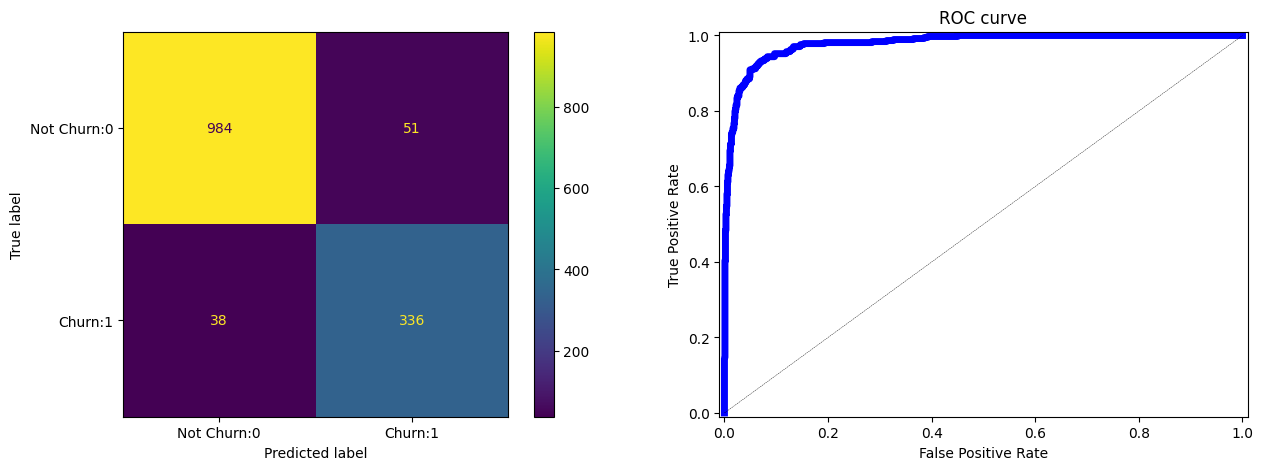

In [ ]:
from sklearn.metrics import roc_curve, ConfusionMatrixDisplay

## Roc curve
fpr, tpr, thr = roc_curve(y_test, y_pred_pro[:,1])

## plot
plt.figure(figsize =(15,5))
layout = (1,2)

cmd = plt.subplot2grid(layout,(0,0))
rc = plt.subplot2grid(layout,(0,1))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax = cmd)
cmd.xaxis.set_ticklabels(["Not Churn:0", "Churn:1"])
cmd.yaxis.set_ticklabels(["Not Churn:0", "Churn:1"])

rc.plot(fpr, tpr, color ='blue', linewidth = 5)
rc.plot([0, 1],[0, 1], ls = '--', color = 'black', lw = .3)
rc.set(xlabel = 'False Positive Rate',
       ylabel = 'True Positive Rate',
       xlim =[-.01, 1.01], ylim =[-.01, 1.01],
       title = 'ROC curve')

plt.show()

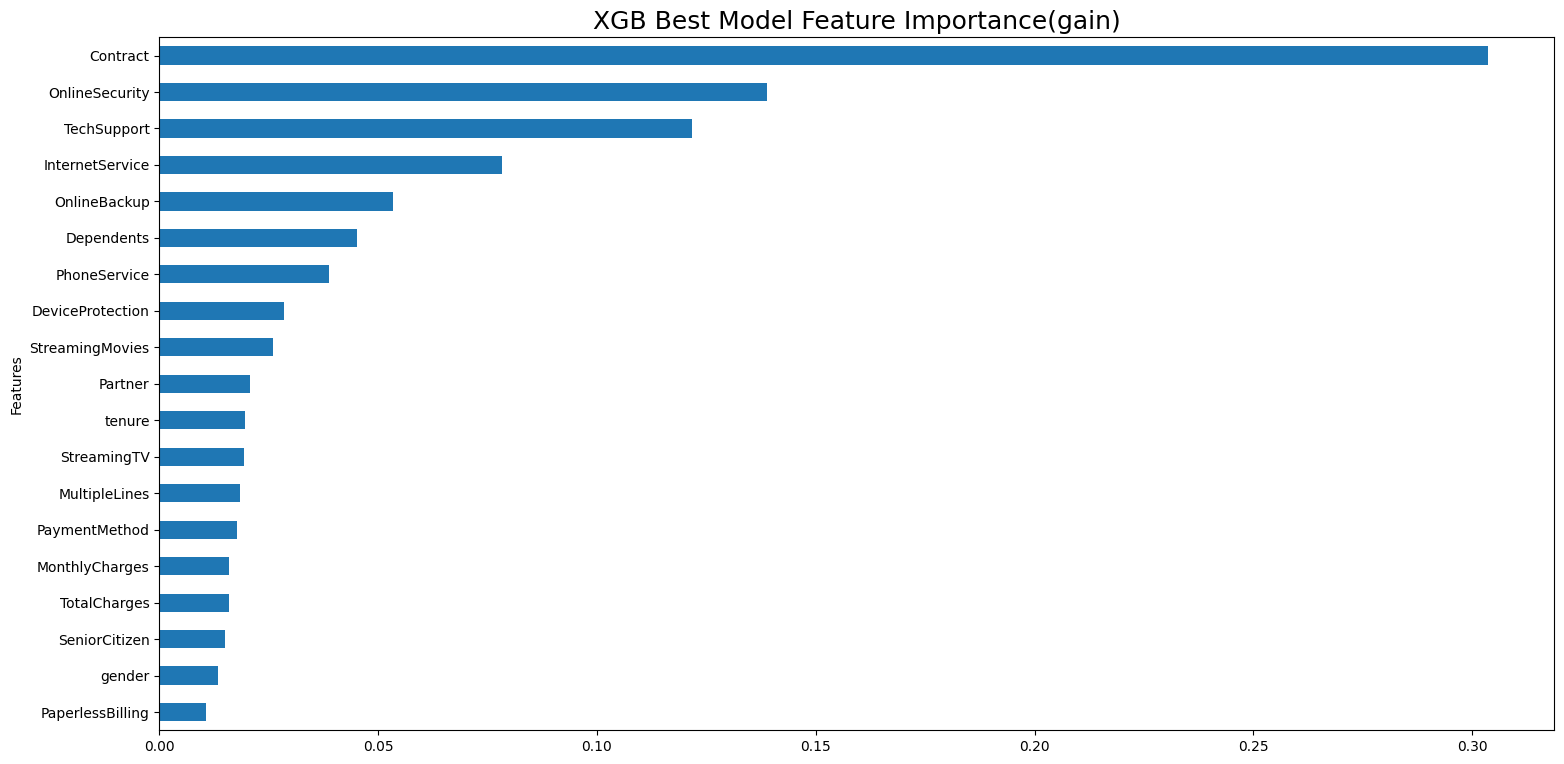

In [ ]:
## Feature importance
fea_imp_xgb = pd.Series(best_model.feature_importances_, index = X_train.columns)

# plot
fea_imp_xgb.sort_values(ascending = True).plot(kind = 'barh', figsize = (18, 9))
plt.xlabel('')
plt.ylabel('Features')
plt.title('XGB Best Model Feature Importance(gain)', fontsize = 18);

In [ ]:
with open("/content/drive/My Drive/telecomchurn/customer_churn_xgb_model.pkl", "wb") as f:
  joblib.dump(best_model, f)